In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from astropy.io import ascii
from astropy.table import Table, Column

%matplotlib inline

In [344]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [397]:
cat = ascii.read('cat_lau.csv')

In [419]:
RA = cat['RAh'] + cat['RAm']*(1/60.) + cat['RAs']*(1./3600.)
Dec= -1 * (cat['DEd']*u.deg + cat['DEm']*u.arcmin + cat['DEs']*u.arcsec)
coord = SkyCoord(ra=RA*15.*u.deg, dec=Dec)

In [443]:
cat['l'] = coord.galactic.l.deg
cat['b'] = coord.galactic.b.deg

cat['J-Ks'] = cat['J$_{2\\prime\\prime}$'] - cat['Ks$_{2\\prime\\prime}$']
cat['H-Ks'] = cat['H$_{2\\prime\\prime}$'] - cat['Ks$_{2\\prime\\prime}$']
cat['J-H'] = cat['J$_{2\\prime\\prime}$'] - cat['H$_{2\\prime\\prime}$']

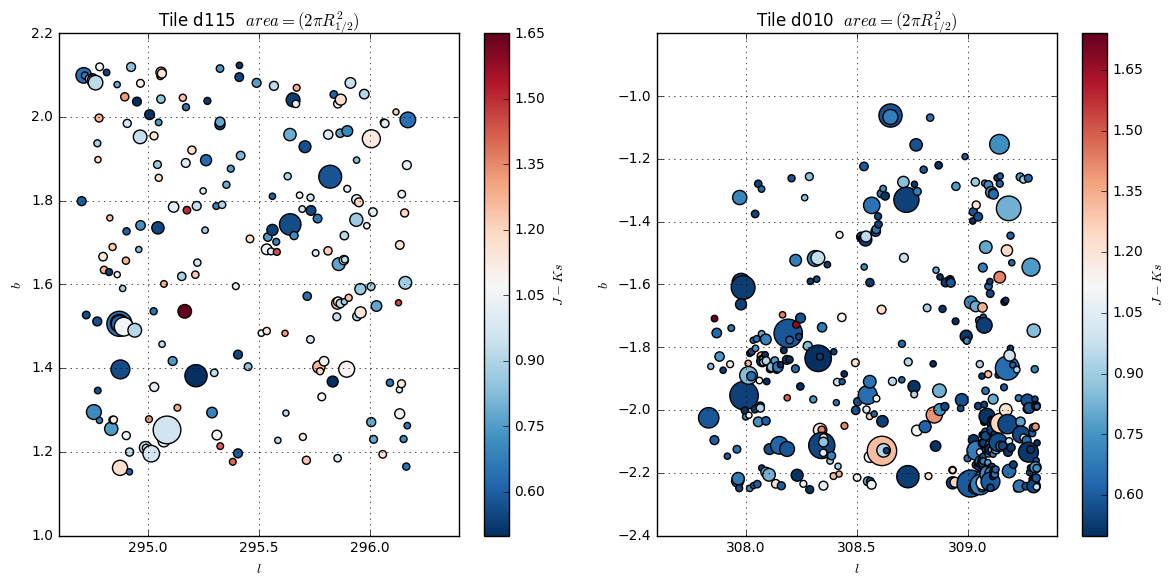

In [505]:
plt.figure(figsize=(12, 6))
#plt.suptitle(r'$(2 \pi R_{1/2}^2)$', fontsize=14)
plt.subplot(121)
plt.scatter(cat['l'][cat['b']>0.], 
            cat['b'][cat['b']>0.], 
            c=cat['J-Ks'][cat['b']>0.],
            s=3.*2*np.pi*cat['R$_{1/2}$'][cat['b']>0.]**2.,
            cmap='RdBu_r')
plt.colorbar(label=r'$J-Ks$')
plt.title(r'Tile d115  $area=(2 \pi R_{1/2}^2)$')
plt.xlabel(r'$l$')
plt.ylabel(r'$b$')
plt.grid()

plt.subplot(122)
plt.scatter(cat['l'][cat['b']<0.], 
            cat['b'][cat['b']<0.], 
            c=cat['J-Ks'][cat['b']<0.],
            s=3.*2*np.pi*cat['R$_{1/2}$'][cat['b']<0.]**2.,
            cmap='RdBu_r')
plt.colorbar(label=r'$J-Ks$')
plt.title(r'Tile d010  $area=(2 \pi R_{1/2}^2)$')
plt.xlabel(r'$l$')
plt.ylabel(r'$b$')
plt.grid()
plt.tight_layout()
plt.show()

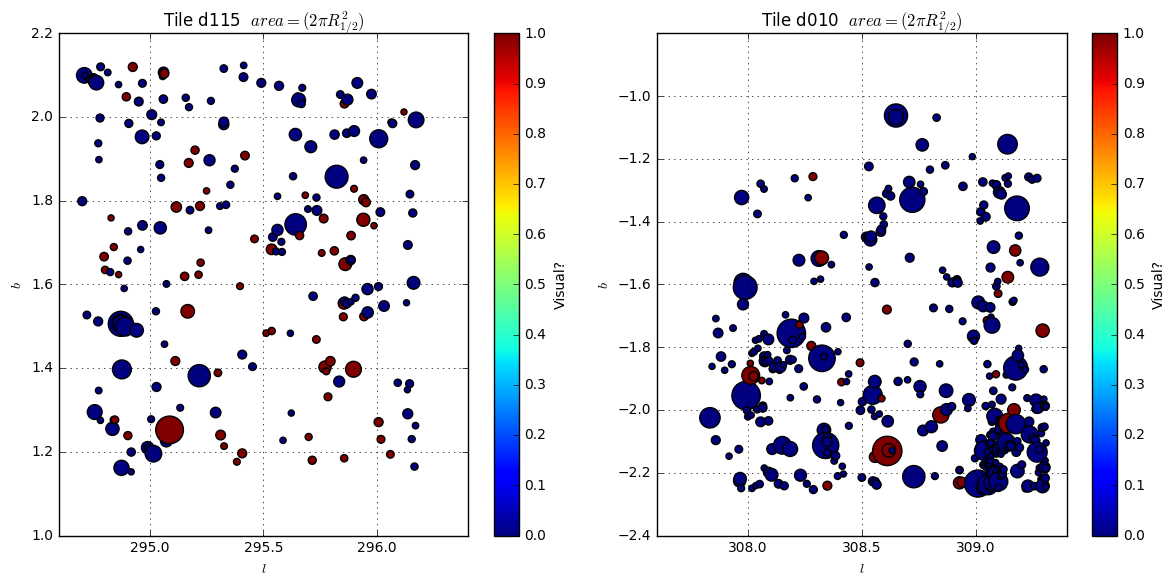

In [540]:
plt.figure(figsize=(12, 6))
#plt.suptitle(r'$(2 \pi R_{1/2}^2)$', fontsize=14)
plt.subplot(121)
plt.scatter(cat['l'][cat['b']>0.], 
            cat['b'][cat['b']>0.], 
            c=cat['Visual'][cat['b']>0.]=='True',
            s=3.*2*np.pi*cat['R$_{1/2}$'][cat['b']>0.]**2.)
            #cmap='tab10')
plt.colorbar(label=r'Visual?')
plt.title(r'Tile d115  $area=(2 \pi R_{1/2}^2)$')
plt.xlabel(r'$l$')
plt.ylabel(r'$b$')
plt.grid()

plt.subplot(122)
plt.scatter(cat['l'][cat['b']<0.], 
            cat['b'][cat['b']<0.], 
            c=cat['Visual'][cat['b']<0.]=='True',
            s=3.*2*np.pi*cat['R$_{1/2}$'][cat['b']<0.]**2.)
            #cmap='RdBu_r')
plt.colorbar(label=r'Visual?')
plt.title(r'Tile d010  $area=(2 \pi R_{1/2}^2)$')
plt.xlabel(r'$l$')
plt.ylabel(r'$b$')
plt.grid()
plt.tight_layout()
plt.show()

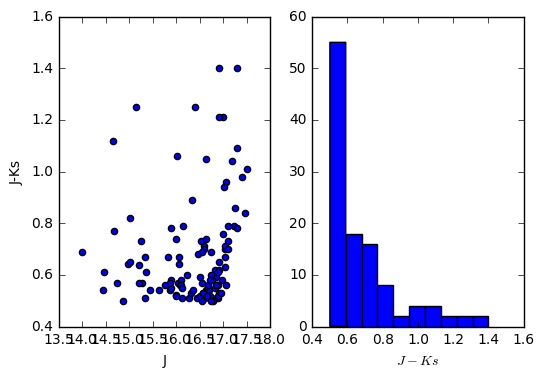

In [511]:
filtrado = (cat['l']>308.8) & (cat['b']<-2.)
plt.subplot(121)
plt.scatter(cat['J'][filtrado], cat['J-Ks'][filtrado])
plt.xlabel('J')
plt.ylabel('J-Ks')
plt.subplot(122)
plt.hist(cat['J-Ks'][filtrado])
plt.xlabel(r'$J-Ks$')

In [3]:
d010 = ascii.read('d010_resto.dat', format='ipac')
d115 = ascii.read('d115_resto.dat', format='ipac')

In [4]:
print cat.colnames

['Id', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'Z', 'Y', 'J', 'H', 'Ks', 'Z$_{2\\prime\\prime}$', 'Y$_{2\\prime\\prime}$', 'J$_{2\\prime\\prime}$', 'H$_{2\\prime\\prime}$', 'Ks$_{2\\prime\\prime}$', 'R$_{1/2}$', 'C', '$\\epsilon$', 'n', 'Visual']


In [541]:
gxs = cat[['J', 'H', 'Ks', 'J-Ks', 'J-H', 'H-Ks', 'R$_{1/2}$', 'C', '$\\epsilon$', 'n']].to_pandas()

In [542]:
d010['J-Ks'] = d010['MAG_APER_J_C'] - d010['MAG_APER_Ks_C']
d010['H-Ks'] = d010['MAG_APER_H_C'] - d010['MAG_APER_Ks_C']
d010['J-H'] = d010['MAG_APER_J_C'] - d010['MAG_APER_H_C']
d115['J-Ks'] = d115['MAG_APER_J_C'] - d115['MAG_APER_Ks_C']
d115['H-Ks'] = d115['MAG_APER_H_C'] - d115['MAG_APER_Ks_C']
d115['J-H'] = d115['MAG_APER_J_C'] - d115['MAG_APER_H_C']

In [543]:
strs_d010= d010[['MAG_PSF_J_C','MAG_PSF_H_C','MAG_PSF_Ks_C', 'J-Ks', 'J-H', 'H-Ks',
            'FLUX_RADIUS_051','C','ELLIPTICITY','SPHEROID_SERSICN']].to_pandas()

In [544]:
strs_d115= d115[['MAG_PSF_J_C','MAG_PSF_H_C','MAG_PSF_Ks_C', 'J-Ks', 'J-H', 'H-Ks',
                 'FLUX_RADIUS_051','C','ELLIPTICITY','SPHEROID_SERSICN']].to_pandas()

In [545]:
strs = pd.concat([strs_d010, strs_d115])

In [546]:
strs = strs[strs.MAG_PSF_J_C < 30]
gxs = gxs[gxs.J<30]

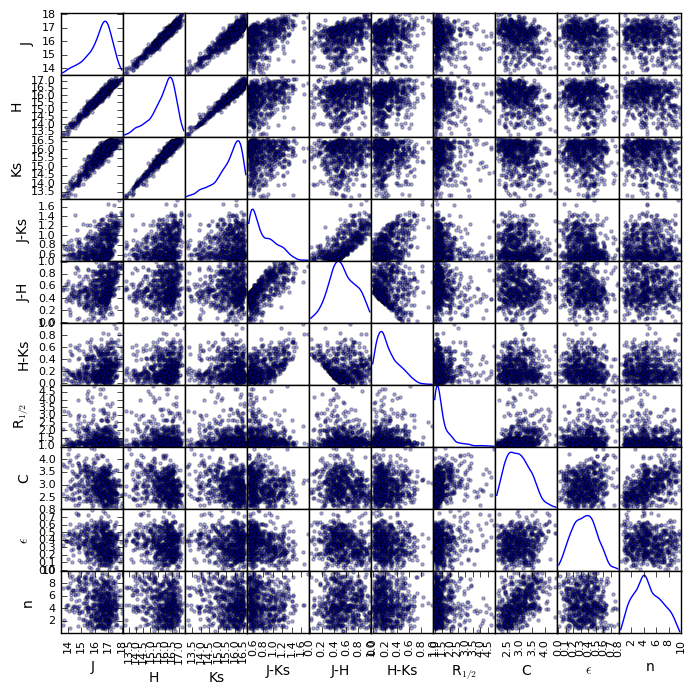

In [547]:
pd.scatter_matrix(gxs,  alpha=0.3, figsize=(8, 8), diagonal='kde')
plt.show()

In [548]:
strs = strs[(strs.MAG_PSF_J_C>12.)&(strs.MAG_PSF_H_C>12.)&(strs.MAG_PSF_Ks_C>12.)&(strs.C>0.)]
strs = strs[(strs.MAG_PSF_J_C<25.)&(strs.MAG_PSF_H_C<25.)&(strs.MAG_PSF_Ks_C<25.)&(strs.FLUX_RADIUS_051<5.)]
print 'now we have {} stars'.format(len(strs))
print r'After $R_{1/2}<1.005$ we have'+ '  {} stars'.format(len(strs[strs.FLUX_RADIUS_051>1.005]))
strs = strs[strs.FLUX_RADIUS_051>1.005]

now we have 38926 stars
After $R_{1/2}<1.005$ we have  3656 stars


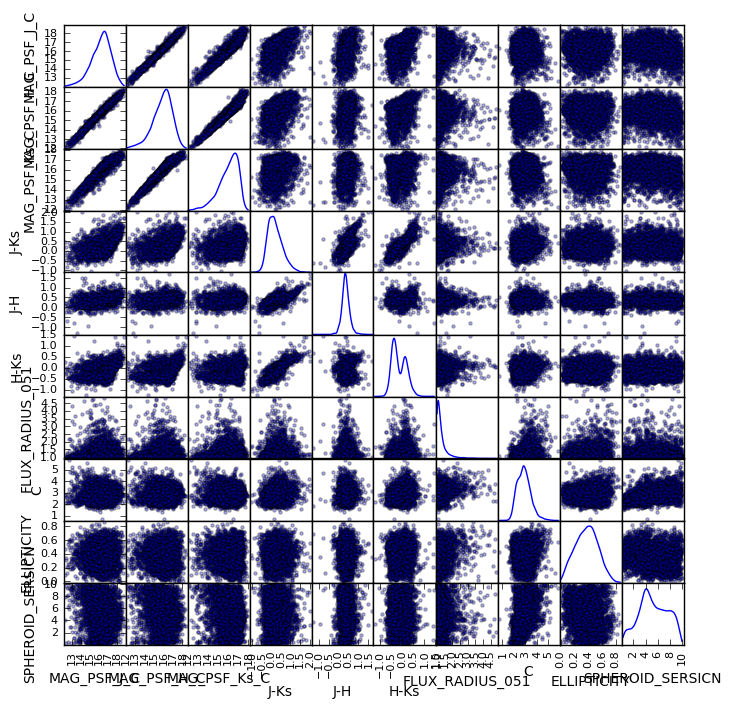

In [549]:
pd.scatter_matrix(strs,  alpha=0.3, figsize=(8, 8), diagonal='kde')
plt.show()

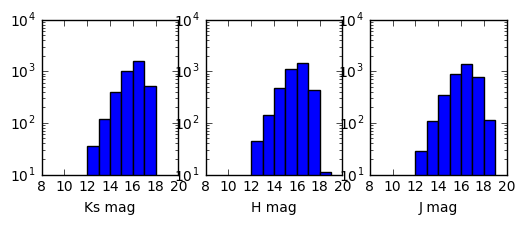

In [551]:
bins = np.arange(9, 20, 1.)

plt.figure(figsize=(6, 2))
plt.subplot(131)
plt.hist(strs['MAG_PSF_Ks_C'], log=True, bins=bins)
plt.xlabel(r'Ks mag')
plt.subplot(132)
plt.hist(strs['MAG_PSF_H_C'], log=True, bins=bins)
plt.xlabel(r'H mag')
plt.subplot(133)
plt.hist(strs['MAG_PSF_J_C'], log=True, bins=bins)
plt.xlabel(r'J mag')

plt.show()

In [552]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import neighbors
import sklearn.cross_validation as cv
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [553]:
def experiment(clf, x, y, nfolds=10):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:, 0]

        probabilities = np.hstack([probabilities, probs])
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities)
    pr_rec_curve = metrics.precision_recall_curve(y_testing, 1.-probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'pr_rec_curve': pr_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

In [554]:
#choices = np.random.choice(40000, 2000)
strs2 = strs

In [555]:
X = np.vstack((strs2.as_matrix(), gxs.as_matrix()))
Y = np.hstack((np.repeat(0, len(strs2)), np.repeat(1, len(gxs))))

### Decision Tree (gini)

In [556]:
res_Dtree = experiment(DecisionTreeClassifier(max_leaf_nodes=12), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.96      0.95      0.96      3656
        1.0       0.72      0.77      0.75       572

avg / total       0.93      0.93      0.93      4228



### K-Neirest Neighbors

In [557]:
res_knn = experiment(neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform'), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.92      0.93      0.93      3656
        1.0       0.54      0.50      0.52       572

avg / total       0.87      0.87      0.87      4228



### Support Vector Machines

In [563]:
res_svc = experiment(svm.SVC(kernel='linear', probability=True), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.89      0.97      0.93      3656
        1.0       0.56      0.24      0.34       572

avg / total       0.85      0.87      0.85      4228



## Random Forest

In [574]:
res_Rforest = experiment(RandomForestClassifier(n_estimators=1000, 
                                                max_features=8, 
                                                min_samples_leaf=20,
                                                n_jobs=8), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.97      0.96      0.96      3656
        1.0       0.74      0.78      0.76       572

avg / total       0.94      0.93      0.93      4228



### C45

In [565]:
res_C45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=15), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.96      0.95      0.96      3656
        1.0       0.72      0.78      0.75       572

avg / total       0.93      0.93      0.93      4228



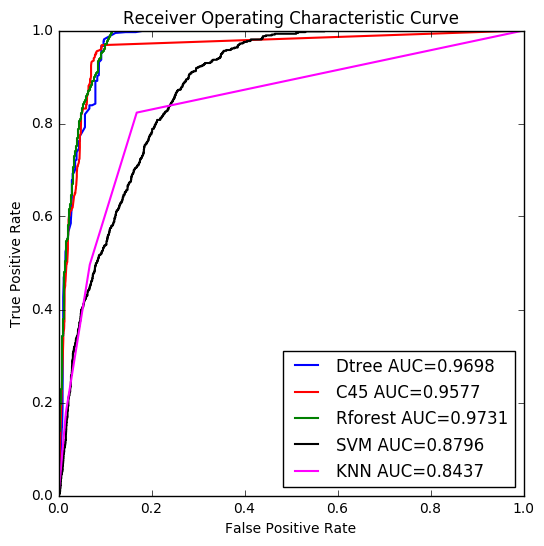

In [575]:
plt.figure(figsize=(6, 6))
#plt.figaspect(.8)

fpr = res_Dtree['fpr']
tpr = res_Dtree['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(roc_auc))

fpr = res_C45['fpr']
tpr = res_C45['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(roc_auc))

fpr = res_Rforest['fpr']
tpr = res_Rforest['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(roc_auc))

fpr = res_svc['fpr']
tpr = res_svc['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(roc_auc))

fpr = res_knn['fpr']
tpr = res_knn['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(roc_auc))

#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic Curve')

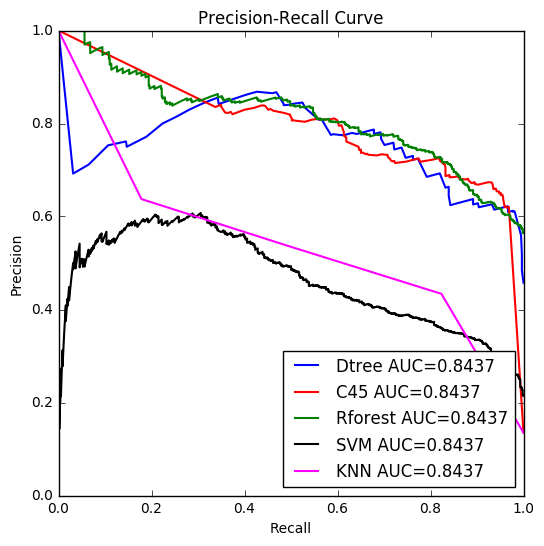

In [576]:
plt.figure(figsize=(6, 6))
#plt.figaspect(.8)

pr, rec, thr = res_Dtree['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_C45['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_Rforest['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_svc['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_knn['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(roc_auc))

#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.title('Precision-Recall Curve')

## Outer Testing with all stars

In [569]:
clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10)
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

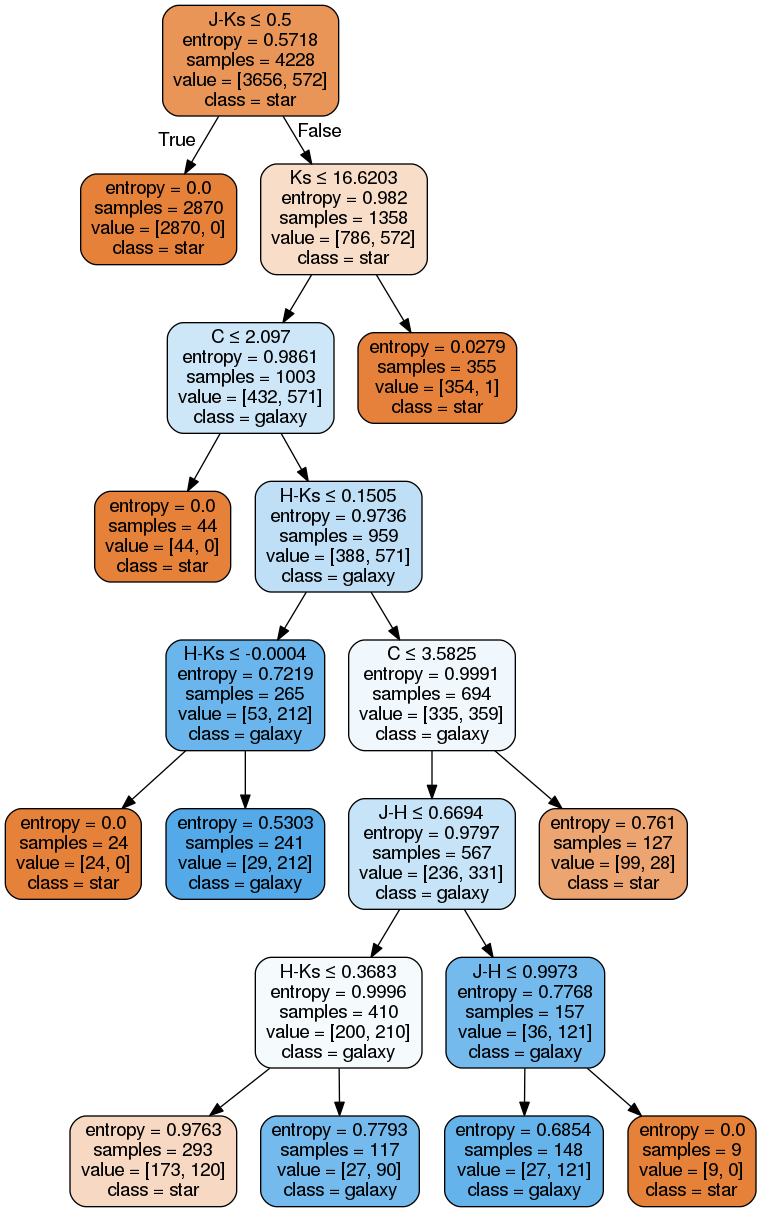

In [570]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=gxs.columns, 
                           class_names=['star', 'galaxy'],  
                           filled=True, 
                           rounded=True,
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  